<a href="https://colab.research.google.com/github/ritwikraha/CV-Practice/blob/master/TrOCRvsPaddleOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrOCR vs PaddleOCR

This notebook is meant to check how different OCR models such as TrOCR perform on custom data such as a comic strip.

`Argument: While comic strips often have legible fonts, they are notoriously hard to detect due to the occurence of other objects and patterns around them. Thus making them a suitable test-case for such models`


- The PP-OCR (PaddlePaddle OCR) model is composed of the DB+CRNN algorithm.

- TrOCR consists of an image Transformer encoder and an autoregressive text Transformer decoder to perform OCR on images

## Setup and Installations

In [1]:
!pip install -q transformers
!pip install paddlepaddle
!pip install "paddleocr>=2.0.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.7/465.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

## Load image



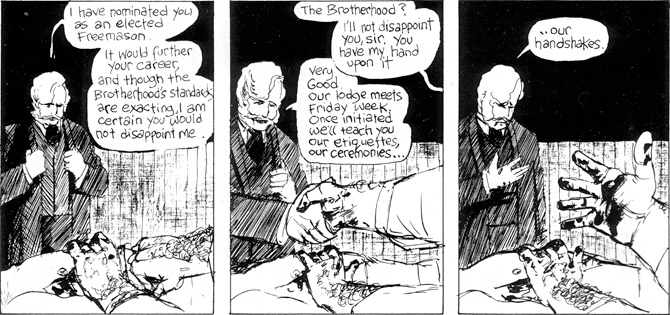

In [2]:
import requests
from PIL import Image

url = "https://i.imgur.com/1yTuQpT.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

# TrOCR

## Prepare image for TrOCR model

Next, we use `TrOCRProcessor` (which wraps a `ViTFeatureExtractor` and a `RobertaTokenizer` into one) to resize + normalize the image for the model.

In [3]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# calling the processor is equivalent to calling the feature extractor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

torch.Size([1, 3, 384, 384])


## Load model

Load a TrOCR model from the [hub](https://huggingface.co/models?other=trocr).

Apparently TrOCR models are instances of [`VisionEncoderDecoderModel`](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder),

In [4]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Generate text from TrOCR

Finally, we can generate text autoregressively using the `.generate()` method. We use the tokenizer part of the `processor` to decode the generated id's back to text.

In [43]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, max_new_tokens=1000, skip_special_tokens=True)[0]

In [44]:
print(generated_text)

" Brownhill Missouri FIRST


# PaddleOCR

## Load the model

Here we load the ocr model from PaddleOCR .Paddleocr supports Chinese, English, French, German, Korean and Japanese.
You can set the parameter `lang` as `ch`, `en`, `french`, `german`, `korean`, `japan`
to switch the language model in order.



In [6]:
from paddleocr import PaddleOCR,draw_ocr

ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:14<00:00, 286kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:15<00:00, 666kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:08<00:00, 256kiB/s]


[2023/12/26 18:37:14] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

## Preprocess Data

make sure that the data is in opencv format for the model to process

In [11]:
import cv2
import numpy

img = numpy.array(image)
# Convert RGB to BGR
img = img[:, :, ::-1].copy()

## Generate Text using PaddleOCR

In the following code snippet we see how to generate the text for each bounding box detected

To learn how PaddleOCR works read the documentation [here](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.7/doc/doc_en/models_en.md) or start the e-book [here](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.7/doc/doc_en/ocr_book_en.md).

In [32]:
result = ocr.ocr(img, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

[2023/12/26 19:02:54] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.1154944896697998
[2023/12/26 19:02:54] ppocr DEBUG: cls num  : 25, elapsed : 0.10350966453552246
[2023/12/26 19:02:55] ppocr DEBUG: rec_res num  : 25, elapsed : 0.9891817569732666
[[[70.0, 5.0], [194.0, 4.0], [194.0, 18.0], [70.0, 19.0]], ('have nominated yoL)', 0.8488809466362)]
[[[296.0, 3.0], [407.0, 0.0], [408.0, 17.0], [296.0, 20.0]], ('The Brotherhood?', 0.9256867170333862)]
[[[73.0, 18.0], [166.0, 16.0], [167.0, 29.0], [73.0, 32.0]], ('as an elected', 0.9207031726837158)]
[[[341.0, 19.0], [434.0, 18.0], [434.0, 32.0], [341.0, 34.0]], ('Ill not disappoin', 0.8260936141014099)]
[[[77.0, 32.0], [149.0, 32.0], [149.0, 42.0], [77.0, 42.0]], ('Freemason', 0.9823939204216003)]
[[[339.0, 29.0], [416.0, 32.0], [415.0, 48.0], [339.0, 46.0]], ('nosn', 0.5172818303108215)]
[[[539.0, 26.0], [572.0, 26.0], [572.0, 36.0], [539.0, 36.0]], ('OU', 0.7586033344268799)]
[[[339.0, 45.0], [421.0, 45.0], [421.0, 59.0], [339.0, 59.0]], (

## Visualisation in Stages

To visualise the result of the ocr, run the following code, also download the SimFang font from [here](https://huggingface.co/spaces/PaddlePaddle/PaddleOCR/blob/main/simfang.ttf)

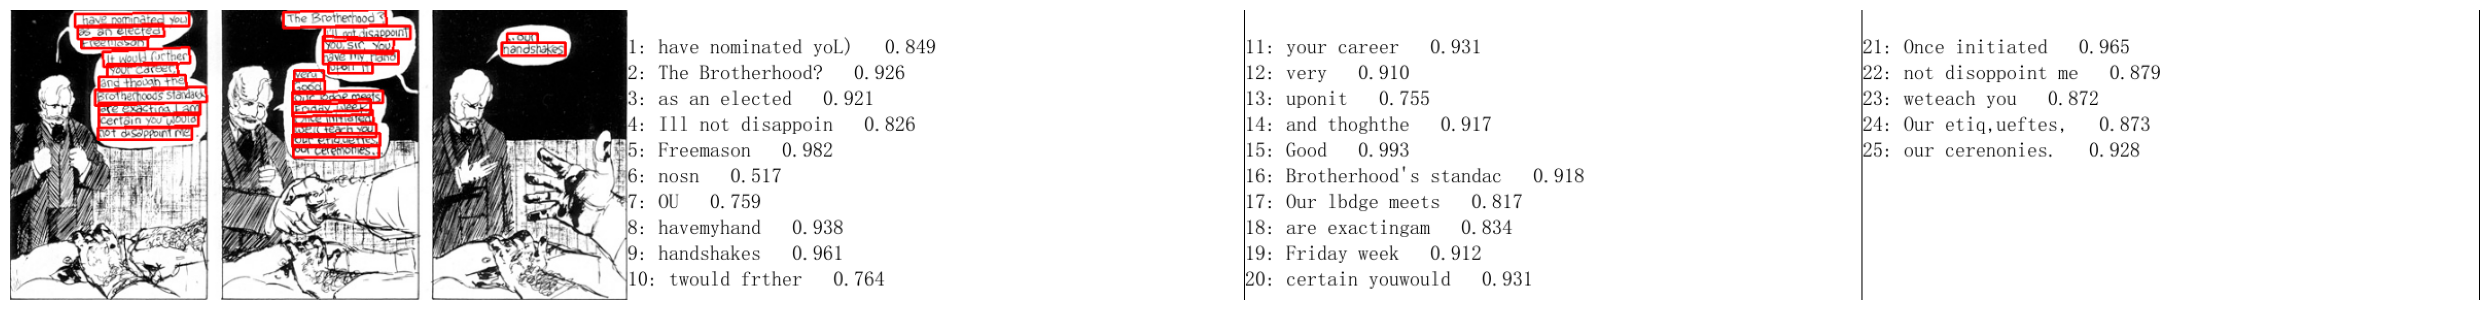

In [42]:
# draw result
from PIL import Image

from PIL import Image
import matplotlib.pyplot as plt


# Initialize a figure for the subplots
num_items = len(result)
fig, axs = plt.subplots(1, num_items, figsize=(num_items * 25, 25))

# Ensure axs is always a list, even when there's only one subplot
if num_items == 1:
    axs = [axs]

for idx, res in enumerate(result):
    boxes = [line[0] for line in res]
    txts = [line[1][0] for line in res]
    scores = [line[1][1] for line in res]

    # Draw OCR results
    im_show = draw_ocr(img, boxes, txts, scores, font_path='/content/simfang.ttf')

    # Plot the image on the corresponding subplot
    axs[idx].imshow(im_show)
    axs[idx].axis('off')  # Turn off axis

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('collage.png')


# Conclusion

On the whole it seems that a DB+CRNN based model far outperforms the Autoregressive model whose output is purely hallucination.


# References

- https://huggingface.co/spaces/nielsr/TrOCR-handwritten/blob/main/app.py
- https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.7/doc/doc_en/models_en.md
- https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.7/doc/doc_en/ppocr_introduction_en.md